In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv("bitcoin.csv")
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28 00:00:00.000,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00.000,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00.000,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00.000,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00.000,103.43,1.148668e+09,0.0


In [44]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['returns'], 100)

In [6]:
returns = pd.DataFrame(df['returns'].dropna())

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.400e+01, 1.130e+02, 1.572e+03,
        1.974e+03, 1.350e+02, 1.400e+01, 1.000e+00]),
 array([-0.43371443, -0.36163308, -0.28955173, -0.21747037, -0.14538902,
        -0.07330767, -0.00122632,  0.07085503,  0.14293638,  0.21501774,
         0.28709909]),
 <BarContainer object of 10 artists>)

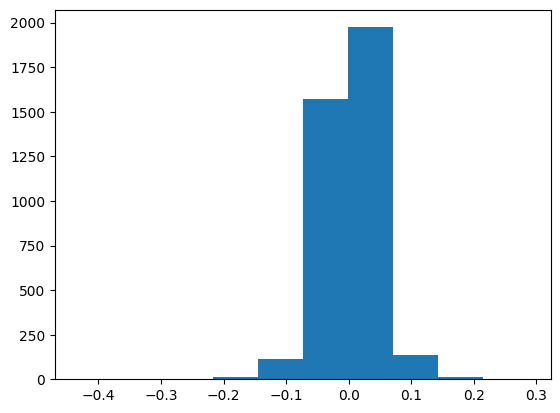

In [7]:
plt.hist(returns['returns'])

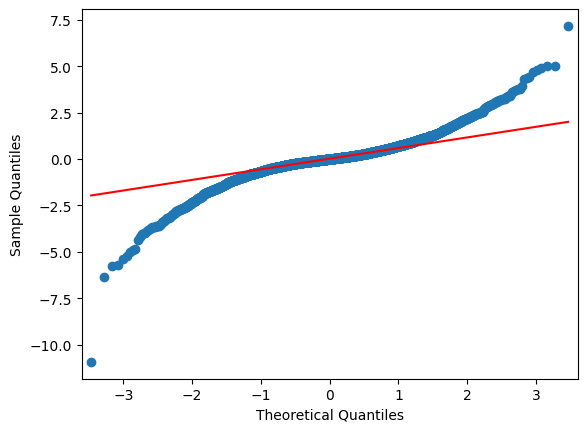

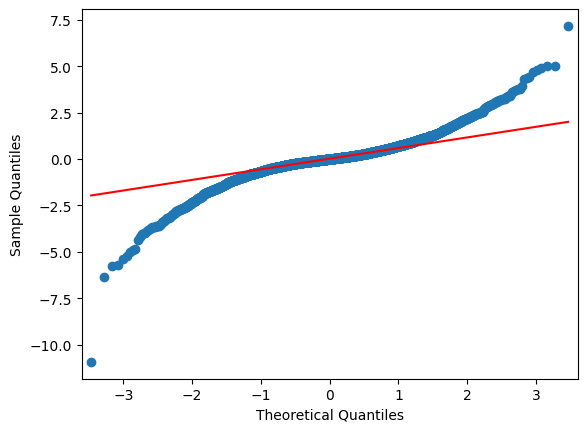

In [8]:
qqplot(returns['returns'], line='q', fit=True)

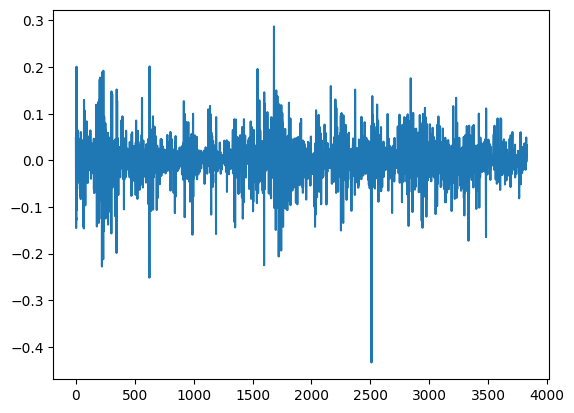

In [9]:
plt.plot(returns['returns'])

In [10]:
from arch import arch_model


In [11]:
m = arch_model(returns['returns'], mean='AR', vol='GARCH', p=1, q=1, lags=3, dist='ged')
r = m.fit(disp=False, options={'ftol': 1e-01})
r.summary()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.001
Mean Model:                                    AR   Adj. R-squared:                 -0.000
Vol Model:                                  GARCH   Log-Likelihood:                7640.10
Distribution:      Generalized Error Distribution   AIC:                          -15264.2
Method:                        Maximum Likelihood   BIC:                          -15214.2
                                                    No. Observations:                 3824
Date:                            Sun, Nov 12 2023   Df Residuals:                     3820
Time:                                    14:53:03   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       1.2236e-03  3.458e-04      3.538  4.026e-04  [5.459e-04,1.901e-03]
returns[1] -5.0170e-03  2.185e-02     -0.230      0.818 [-4.784e-02,3.781e-02]
returns[2] -6.3720e-03  1.455e-02     -0.438      0.661 [-3.489e-02,2.215e-02]
returns[3]      0.0221  1.398e-02      1.580      0.114 [-5.315e-03,4.947e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.1512e-05  4.930e-06      6.392  1.641e-10 [2.185e-05,4.117e-05]
alpha[1]       0.1000  2.017e-02      4.957  7.146e-07   [6.046e-02,  0.140]
beta[1]        0.8800  1.484e-02     59.314      0.000     [  0.851,  0.909]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.183      8.178  2.883e-16 [  1.141,  1.859]
========================================================================

Covariance estimator: robust
"""

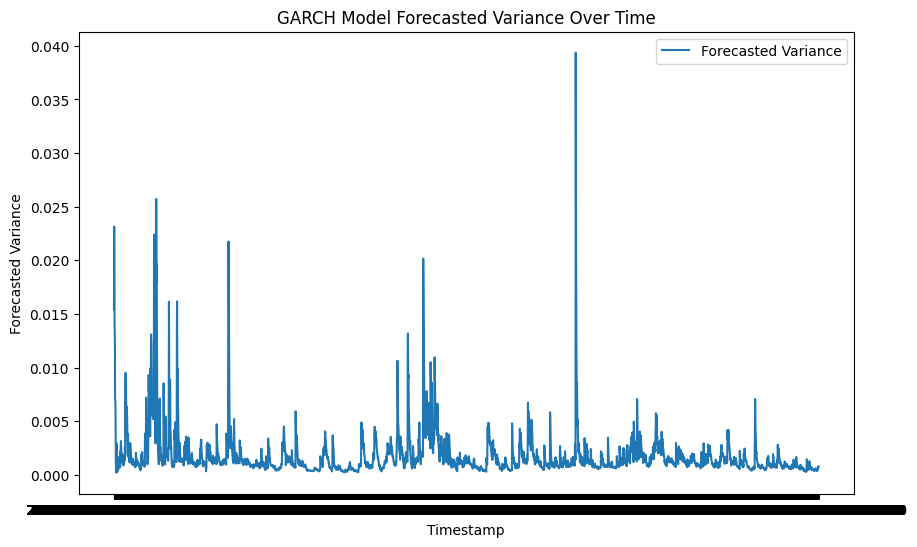

In [47]:
import pandas as pd
from arch import arch_model

# Example: Load your dataset of log returns
# Replace this with your actual data loading code
# df = pd.read_csv('your_log_return_data.csv')
# log_returns = df['log_return_column']

# For demonstration, I'm using dummy data
# Replace this with your actual log returns data

df = df.dropna(subset=['log_returns'])

def recursive_forecast(log_returns, window):
    forecasts = {}
    log_returns = df['log_returns']
    for i in range(window, len(log_returns)):
        # Fit the GARCH model
        model = arch_model(log_returns[:i], mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = model.fit(disp='off')

        # Forecast the next value
        forecast = model_fit.forecast(horizon=1)
        forecasts[log_returns.index[i]] = forecast.variance.iloc[-1, 0]

    return pd.DataFrame(forecasts, index=['Forecast']).T

# Set your forecasting window
window = 5  # Adjust this based on your dataset

# Perform recursive forecasting
forecast_results = recursive_forecast(df, window)
# print(forecast_results)

plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'][window:], forecast_results, label='Forecasted Variance')
plt.title('GARCH Model Forecasted Variance Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Forecasted Variance')
plt.legend()
plt.show()

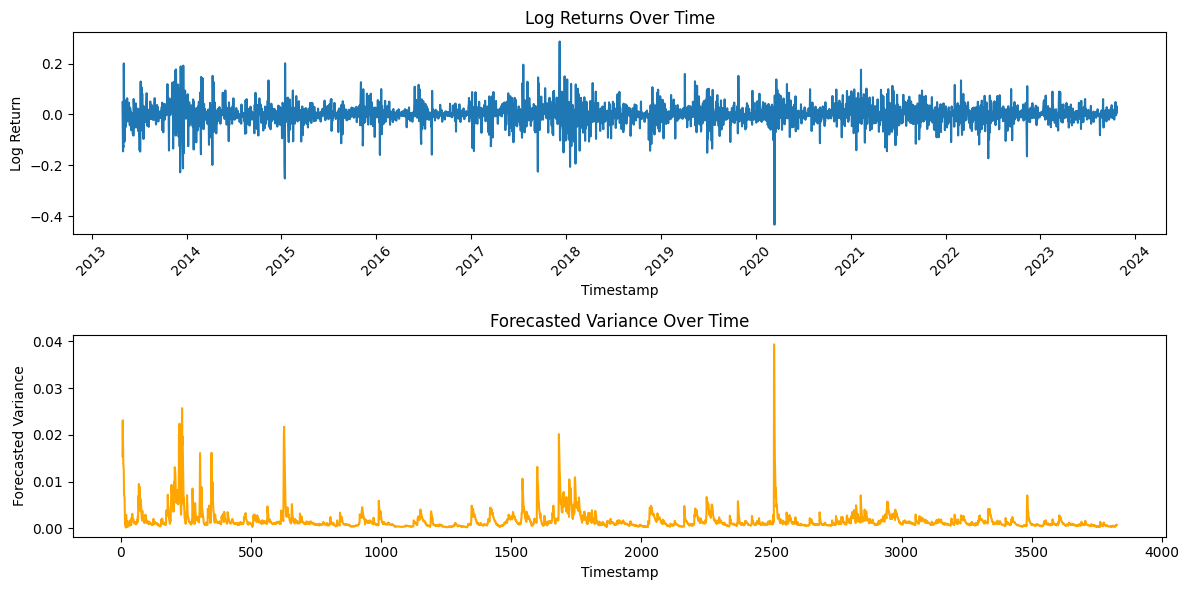

In [54]:
# Assuming forecast_results and df are already defined
import matplotlib.dates as mdates
df['timestamp'] = pd.to_datetime(df['timestamp'])

plt.figure(figsize=(12, 6))

# Plotting log returns
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['log_returns'], label='Log Returns')
plt.title('Log Returns Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Log Return')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show one label per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format labels as years
plt.xticks(rotation=45)  # Rotate labels


# Plotting forecasted variance
plt.subplot(2, 1, 2)
plt.plot(forecast_results.index, forecast_results, label='Forecasted Variance', color='orange')
plt.title('Forecasted Variance Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Forecasted Variance')

plt.tight_layout()
plt.show()

In [57]:
model = arch_model(df['log_returns'], mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Print AIC and BIC
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)

AIC: -14653.870092353738
BIC: -14635.120582897462
